Welcome to the feature selection notebook!  In the third notebook, we made a choice of features and tried running a large number of models on the same set of features, tuning parameters for each model.  That analysis suggested that random forest was a good model with which to move forward, with the following parameters: 100 estimators, depth 7, and number of samples per estimator 7000.

In this notebook we stick with these parameters for random forest, and compare what happens when we select different sets of features (columns) to be in our DataFrame.  We start by computing many different ways to adjust and combine our existing features, then test what happens when we include or exclude different families of features.

The code for setting up is similar to that of the previous notebook.

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("../Data/default.csv", skiprows=1, index_col = "ID")

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
df_train, df_test = train_test_split(df.copy(),
                                        shuffle = True,
                                        random_state = 167,
                                        test_size = .2,
                                        stratify = df["default payment next month"])

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from seaborn import set_style
set_style("whitegrid")

def lift_chart(trueproba, predproba):
    fprs, tprs, cutoffs = roc_curve(trueproba, predproba)
    p = sum(trueproba)/len(trueproba)
    x = (1-p)*fprs + p*tprs # proportion of all people selected as 1
    y = p*tprs # proportion of all people correctly selected as 1
    
    plt.figure(figsize=(10,8))

    plt.plot(x, y, label="Lift Chart")
    plt.plot([0,1], [0,p], 'r--', label="Random Guess")
    plt.plot([0,p,1], [0,p,p], 'k--', label="Perfect Guess")

    plt.xlabel("Selected as Defaulters", fontsize=16)
    plt.ylabel("Defaulters Correctly Identified", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)

    plt.show()
    
def area_ratio(trueproba, predproba):
    # linear transformation from ROC curve to lift chart multiplies all areas by p(1-p), 
    # hence doesn't change the ratio
    return (roc_auc_score(trueproba, predproba) - .5) / .5

In [7]:
def expand_columns(df_original):
    df_new = df_original.copy()
    df_new.rename(columns={"PAY_0":"PAY_1"}, inplace=True)
    
    # clean up the payment lateness so each month is either paid in full, paid on time carrying balance, or late
    for i in range(1, 7):
        df_new["CLEANPAY_"+str(i)] = df_new["PAY_"+str(i)].copy()
        df_new.loc[df_new["CLEANPAY_"+str(i)] > 0, "CLEANPAY_"+str(i)] = 1
        df_new.loc[df_new["CLEANPAY_"+str(i)] < 0, "CLEANPAY_"+str(i)] = -1

    # clean up demographic info    
    df_new["CLEANSEX"] = df_new["SEX"].copy()
    df_new.loc[(df_new.CLEANSEX != 1) & 
               (df_new.CLEANSEX != 2), "CLEANSEX"] = 2 # if not male or female, assign female
    df_new["CLEANMARRIAGE"] = df_new["MARRIAGE"].copy()
    df_new.loc[(df_new.CLEANMARRIAGE != 1) & 
               (df_new.CLEANMARRIAGE != 2), "CLEANMARRIAGE"] = 1.5 # assign other marital status to intermediate
    # make one-hot encoding for both marriage and cleanmarriage
    df_new = pd.concat([df_new, 
                        pd.get_dummies(df_new["MARRIAGE"], prefix="MARRIAGE"), 
                        pd.get_dummies(df_new["CLEANMARRIAGE"], prefix="CLEANMARRIAGE")], 
                       axis=1)
    
    # break EDUCATION into three binary variables
    df_new["GRAD"] = 1*(df_original.EDUCATION == 1)
    df_new["UNIV"] = 1*((df_original.EDUCATION == 1) | (df_original.EDUCATION == 1))
    df_new["EDU_OTHER"] = 1*((df_original.EDUCATION != 1) & 
                             (df_original.EDUCATION != 2) & 
                             (df_original.EDUCATION != 3))
#     df_new.drop(columns=["EDUCATION"], inplace=True)
    df_new["CLEANEDU"] = df_new["EDUCATION"].copy()
    df_new.loc[(df_new.EDUCATION != 1) & 
               (df_new.EDUCATION != 2) & 
               (df_new.EDUCATION != 3), "CLEANEDU"] = 4
    df_new = pd.concat([df_new, 
                        pd.get_dummies(df_new["EDUCATION"], prefix="EDU"), 
                        pd.get_dummies(df_new["CLEANEDU"], prefix="CLEANEDU")], 
                       axis=1)

    for i in range(1, 6):
    # record the portion of last bill that was not paid down each month
        df_new["DEBT_AMT"+str(i)] = df_new["BILL_AMT"+str(i+1)] - df_new["PAY_AMT"+str(i)]    
    for i in range(1, 6):
    # record the amounts of new charges for each bill
        df_new["CHARGE_AMT"+str(i)] = (df_new["BILL_AMT"+str(i)] - df_new["DEBT_AMT"+str(i)])
    for i in range(1, 5):
        # are they paying down their debt or increasing it?
        df_new["DEBT_DIFF"+str(i)] = df_new["DEBT_AMT"+str(i)] - df_new["DEBT_AMT"+str(i+1)]
    for i in range(1, 7):
        df_new["BILL_FRAC"+str(i)] = df_new["BILL_AMT"+str(i)]/df_new["LIMIT_BAL"]
    for i in range(1, 6):
    # record the fraction of last bill that was paid
        df_new["PAY_FRAC"+str(i)] = df_new["PAY_AMT"+str(i)]/df_new["BILL_AMT"+str(i+1)]
        df_new.loc[df_new["BILL_AMT"+str(i+1)] <= 0, "PAY_FRAC"+str(i)] = 1 # if nothing is billed, they paid in full
    for i in range(1, 6):
    # record the fraction of the limit balance that is the debt
        df_new["DEBT_FRAC"+str(i)] = df_new["DEBT_AMT"+str(i)] / df_new["LIMIT_BAL"]


#     df_new.drop(columns=["BILL_AMT"+str(i) for i in range(1, 7)], inplace=True)

    return df_new

In the code block above, we defined many new columns.  Below we show the full list of columns (rendered as rows so that the names are easier to see).

In [7]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(expand_columns(df_train).head().transpose())

ID,13586,22530,19760,19097,28302
LIMIT_BAL,180000.000000,210000.000000,310000.000000,50000.000000,60000.000000
SEX,2.000000,2.000000,2.000000,2.000000,2.000000
EDUCATION,1.000000,1.000000,1.000000,2.000000,3.000000
MARRIAGE,2.000000,1.000000,1.000000,1.000000,1.000000
AGE,28.000000,40.000000,35.000000,30.000000,34.000000
PAY_1,-1.000000,1.000000,0.000000,0.000000,2.000000
PAY_2,-1.000000,2.000000,0.000000,0.000000,2.000000
PAY_3,-1.000000,2.000000,0.000000,0.000000,2.000000
PAY_4,-1.000000,2.000000,0.000000,0.000000,4.000000
PAY_5,-1.000000,0.000000,0.000000,0.000000,3.000000


In [8]:
def show_splits(L):
    ## L is a list of numpy arrays, each containing the area ratios for each split
    plt.figure(figsize=(16,5))

    for i, a in enumerate(L):
        if i == 0:
            plt.scatter(i*np.ones(len(a)), 
                    a, 
                    s=60, 
                    c='white',
                    edgecolor='black',
                    label="Single Split")
        else:
            plt.scatter(i*np.ones(len(a)), 
                    a, 
                    s=60, 
                    c='white',
                    edgecolor='black')

    plt.scatter(range(len(L)), [np.mean(a) for a in L], s=60, c='r', label="Mean")

    plt.legend(fontsize=14)

    plt.xticks(range(len(L)), [str(i) for i in range(len(L))], fontsize=14, rotation=45)
    plt.yticks(fontsize=14)

    plt.xlabel("Choice of Features", fontsize=16)
    plt.ylabel("Area Ratio", fontsize=16)

    plt.show()

In [9]:
def compare_area_ratios(df_in, model, features_options):
    from itertools import product
    L = [np.zeros(10) for col_set in features_options]
    
    from sklearn.model_selection import StratifiedKFold
    kfold = StratifiedKFold(n_splits = 10, 
                            shuffle = True, 
                            random_state = 173)
    X = expand_columns(df_in.drop(columns=["default payment next month"]))
    y = df_in["default payment next month"]
    i = 0
    for train_index, test_index in kfold.split(X, y):
        X_tt = X.iloc[train_index]
        y_tt = y.iloc[train_index]
        X_ho = X.iloc[test_index]
        y_ho = y.iloc[test_index]

        for j, col_set in enumerate(features_options):
            predproba = model(X_tt, y_tt, X_ho, col_set)
            (L[j])[i] = area_ratio(y_ho.values, predproba)

        i += 1

    for j, col_set in enumerate(features_options):
        print(j)
        print(col_set, "\n")
    show_splits(L)

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


def randomforest(X_train, y_train, X_test, col_set):
    pipe = RandomForestClassifier(n_estimators = 100, max_depth = 7, max_samples = 7000, random_state=36830)
    pipe.fit(X_train[col_set], y_train)
    return pipe.predict_proba(X_test[col_set])[:,1]


In the next code block, we collect the possible features into several lists, for ease of reference.  The list "originals" gives exactly the original columns of our data spreadsheet.  The list "standards" gives the list of columns used in the third notebook, the comparison of models.

In [15]:
statics = ["LIMIT_BAL", "AGE"]
demogs = ["SEX", "MARRIAGE", "EDUCATION"]
cleandemogs = ["CLEANSEX", "CLEANMARRIAGE", "GRAD", "UNIV", "EDU_OTHER"]
dummydemogs = ["SEX"]+["MARRIAGE_"+str(i) for i in range(4)]+["EDU_"+str(i) for i in range(7)]
cleandummydemogs = ["CLEANSEX"]+["CLEANMARRIAGE_1.0", "CLEANMARRIAGE_1.5", "CLEANMARRIAGE_2.0"]+["CLEANEDU_"+str(i) for i in range(1, 5)]
pays = ["PAY_"+str(i) for i in range(1, 7)]
cleanpays = ["CLEANPAY_"+str(i) for i in range(1, 7)]
billamts = ["BILL_AMT"+str(i) for i in range(1, 7)]
payamts = ["PAY_AMT"+str(i) for i in range(1, 7)]
debtamts = ["DEBT_AMT"+str(i) for i in range(1, 6)]
chargeamts = ["CHARGE_AMT"+str(i) for i in range(1, 6)]
debtdiffs = ["DEBT_DIFF"+str(i) for i in range(1, 5)]
billfracs = ["BILL_FRAC"+str(i) for i in range(1, 7)]
payfracs = ["PAY_FRAC"+str(i) for i in range(1, 6)]
debtfracs = ["DEBT_FRAC"+str(i) for i in range(1, 6)]

originals = statics + demogs + pays + billamts + payamts
standards = statics + cleandemogs + pays + payamts + chargeamts + ["DEBT_AMT1"]

We start by comparing some naive possibilities for sets of features that may be relevant.  How do the original and standard features compare to just taking the payment latenesses, or the cleaned/simplified version of the payment latenesses?  What happens if we take the standard features, but swap in different versions of the demographic information, or clean the lateness?  How does this compare to throwing in all the possible columns?

0
['LIMIT_BAL', 'AGE', 'SEX', 'MARRIAGE', 'EDUCATION', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'] 

1
['LIMIT_BAL', 'AGE', 'CLEANSEX', 'CLEANMARRIAGE', 'GRAD', 'UNIV', 'EDU_OTHER', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'CHARGE_AMT1', 'CHARGE_AMT2', 'CHARGE_AMT3', 'CHARGE_AMT4', 'CHARGE_AMT5', 'DEBT_AMT1'] 

2
['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'] 

3
['CLEANPAY_1', 'CLEANPAY_2', 'CLEANPAY_3', 'CLEANPAY_4', 'CLEANPAY_5', 'CLEANPAY_6'] 

4
['LIMIT_BAL', 'AGE', 'SEX', 'MARRIAGE', 'EDUCATION', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'CHARGE_AMT1', 'CHARGE_AMT2', 'CHARGE_AMT3', 'CHARGE_AMT4', 'CHARGE_AMT5', 'DEBT_AMT1'] 

5
['LIMIT_BAL', 'AGE', 

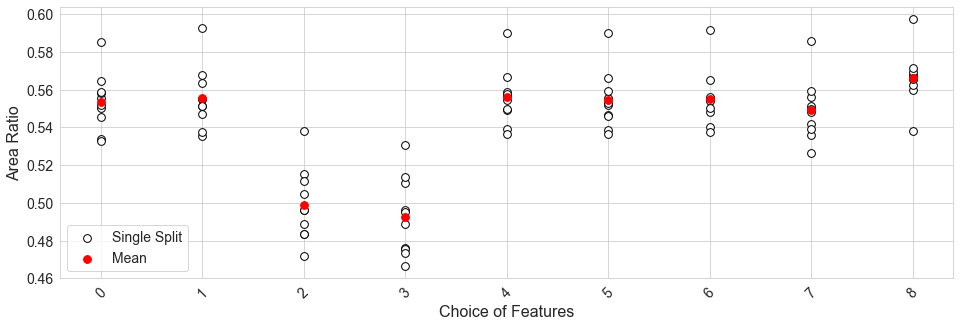

In [16]:
compare_area_ratios(df_train, randomforest, [originals, 
                                              standards, 
                                              pays, 
                                              cleanpays, 
                                              statics + demogs + pays + payamts + chargeamts + ["DEBT_AMT1"], 
                                              statics + dummydemogs + pays + payamts + chargeamts + ["DEBT_AMT1"], 
                                              statics + cleandummydemogs + pays + payamts + chargeamts + ["DEBT_AMT1"], 
                                              statics + cleandemogs + cleanpays + payamts + chargeamts + ["DEBT_AMT1"], 
                                              statics + demogs + cleandemogs + dummydemogs + cleandummydemogs + pays + cleanpays + billamts + payamts + debtamts + chargeamts + debtdiffs + billfracs + payfracs + debtfracs])

Option 8 (all possible features) gives the best score, which is a good sign so far.  Options 2 and 3, with only the payment lateness, do the worst.

It doesn't seem that the encoding of the demographic variables makes much of a difference.  In fact, when varying the demographic encoding, option 4 where we didn't touch the demographic variables at all did as well as any of the others!  Similarly, trying to clean up the record of payment lateness doesn't seem to help---we get slightly more information by not touching it.

Let's run the model again with all possible features, and ask which features were used most by the random forest algorithm.

In [17]:
df_tt, df_ho = train_test_split(expand_columns(df_train.copy()),
                                        shuffle = True,
                                        random_state = 173,
                                        test_size = .2, 
                                        stratify = df_train["default payment next month"])

X_tt = df_tt.drop(columns=["default payment next month"])
y_tt = df_tt["default payment next month"]
pipe = RandomForestClassifier(n_estimators = 100, max_depth = 7, max_samples = 7000, random_state = 36830)
pipe.fit(X_tt, y_tt)
score_df = pd.DataFrame({'feature':X_tt.columns,
                            'importance_score': pipe.feature_importances_})

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(score_df.sort_values('importance_score',ascending=False))

,feature,importance_score
5,PAY_1,0.149023
23,CLEANPAY_1,0.096142
24,CLEANPAY_2,0.058996
6,PAY_2,0.054548
25,CLEANPAY_3,0.039282
7,PAY_3,0.032320
26,CLEANPAY_4,0.024847
9,PAY_5,0.023094
8,PAY_4,0.023073
58,CHARGE_AMT1,0.020808


In approximate order of importance: payment lateness (or cleaned lateness) from most recent to least recent, various billing and payment history information, limit balance and age, and least important is non-age demographic information.

For the moment we'll assume we want to keep the limit balance, the demographic information, and the payment lateness, but we're not sure which of the monetary-amount features we want.  Let's test what happens if we include only the most recent month's monetary amounts, as well as what happens if we include the whole history for each one of the types of monetary amounts separately.

0
['LIMIT_BAL', 'AGE', 'SEX', 'MARRIAGE', 'EDUCATION', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'PAY_AMT1', 'DEBT_AMT1', 'CHARGE_AMT1', 'DEBT_DIFF1', 'BILL_FRAC1', 'PAY_FRAC1', 'DEBT_FRAC1'] 

1
['LIMIT_BAL', 'AGE', 'SEX', 'MARRIAGE', 'EDUCATION', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'CHARGE_AMT1', 'CHARGE_AMT2', 'CHARGE_AMT3', 'CHARGE_AMT4', 'CHARGE_AMT5'] 

2
['LIMIT_BAL', 'AGE', 'SEX', 'MARRIAGE', 'EDUCATION', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_FRAC1', 'PAY_FRAC2', 'PAY_FRAC3', 'PAY_FRAC4', 'PAY_FRAC5'] 

3
['LIMIT_BAL', 'AGE', 'SEX', 'MARRIAGE', 'EDUCATION', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_FRAC1', 'BILL_FRAC2', 'BILL_FRAC3', 'BILL_FRAC4', 'BILL_FRAC5', 'BILL_FRAC6'] 

4
['LIMIT_BAL', 'AGE', 'SEX', 'MARRIAGE', 'EDUCATION', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'] 

5
['LIMIT_BAL', 'AGE', 'SEX', 'MARRIAGE',

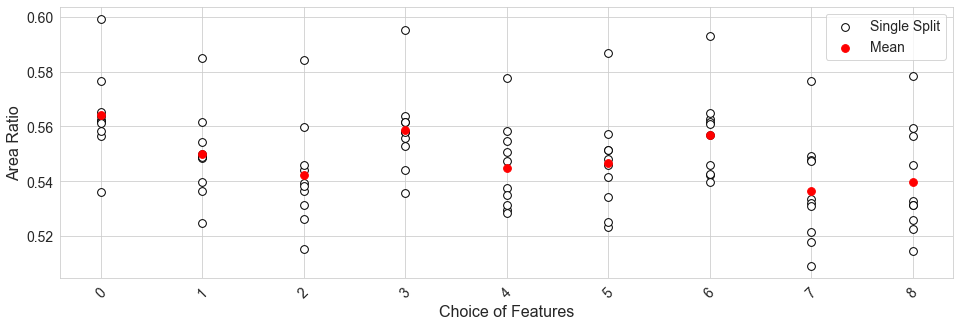

In [18]:
compare_area_ratios(df_train, randomforest, [statics + demogs + pays + ["BILL_AMT1", "PAY_AMT1", "DEBT_AMT1", "CHARGE_AMT1", "DEBT_DIFF1", "BILL_FRAC1", "PAY_FRAC1", "DEBT_FRAC1"], 
                                              statics + demogs + pays + chargeamts,
                                              statics + demogs + pays + payfracs,
                                              statics + demogs + pays + billfracs,
                                              statics + demogs + pays + payamts,
                                              statics + demogs + pays + debtfracs,
                                              statics + demogs + pays + billamts,
                                              statics + demogs + pays + debtamts,
                                              statics + demogs + pays + debtdiffs])

Interestingly, it looks like (option 0) if we include the payment latenesses for all six months, one month's history of the other payment information is just about as good as all of it.

Which factors help the most? The bill as a fraction of the limit balance (option 3), then the total bill amount (option 6), then the charge amount (option 1).

What we just tested was which of the feature types help most on their own.  What about cumulatively?  Next, we order them by the importance we just found, and see when it stops being beneficial to include more feature types.

0
['LIMIT_BAL', 'AGE', 'SEX', 'MARRIAGE', 'EDUCATION', 'PAY_1'] 

1
['LIMIT_BAL', 'AGE', 'SEX', 'MARRIAGE', 'EDUCATION', 'PAY_1', 'BILL_FRAC1'] 

2
['LIMIT_BAL', 'AGE', 'SEX', 'MARRIAGE', 'EDUCATION', 'PAY_1', 'BILL_FRAC1', 'BILL_AMT1'] 

3
['LIMIT_BAL', 'AGE', 'SEX', 'MARRIAGE', 'EDUCATION', 'PAY_1', 'BILL_FRAC1', 'BILL_AMT1', 'CHARGE_AMT1'] 

4
['LIMIT_BAL', 'AGE', 'SEX', 'MARRIAGE', 'EDUCATION', 'PAY_1', 'BILL_FRAC1', 'BILL_AMT1', 'CHARGE_AMT1', 'DEBT_FRAC1'] 

5
['LIMIT_BAL', 'AGE', 'SEX', 'MARRIAGE', 'EDUCATION', 'PAY_1', 'BILL_FRAC1', 'BILL_AMT1', 'CHARGE_AMT1', 'DEBT_FRAC1', 'PAY_AMT1'] 

6
['LIMIT_BAL', 'AGE', 'SEX', 'MARRIAGE', 'EDUCATION', 'PAY_1', 'BILL_FRAC1', 'BILL_AMT1', 'CHARGE_AMT1', 'DEBT_FRAC1', 'PAY_AMT1', 'PAY_FRAC1'] 

7
['LIMIT_BAL', 'AGE', 'SEX', 'MARRIAGE', 'EDUCATION', 'PAY_1', 'BILL_FRAC1', 'BILL_AMT1', 'CHARGE_AMT1', 'DEBT_FRAC1', 'PAY_AMT1', 'PAY_FRAC1', 'DEBT_DIFF1'] 

8
['LIMIT_BAL', 'AGE', 'SEX', 'MARRIAGE', 'EDUCATION', 'PAY_1', 'BILL_FRAC1', 'BILL_AMT1'

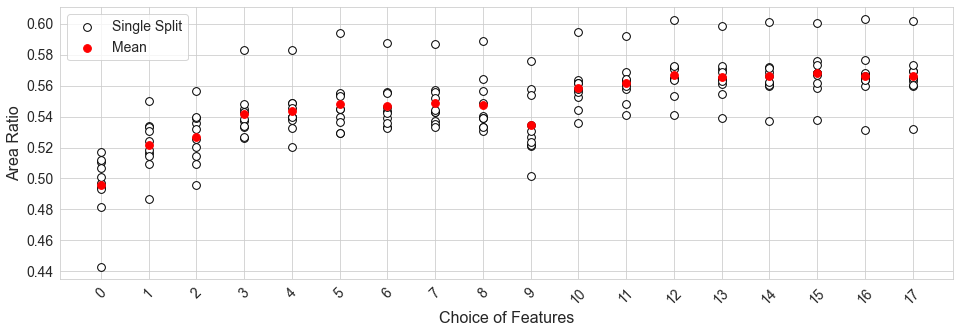

In [19]:
compare_area_ratios(df_train, randomforest, [statics + demogs + ["PAY_1"],
                                              statics + demogs + ["PAY_1", "BILL_FRAC1"],
                                              statics + demogs + ["PAY_1", "BILL_FRAC1", "BILL_AMT1"],
                                              statics + demogs + ["PAY_1", "BILL_FRAC1", "BILL_AMT1", "CHARGE_AMT1"],
                                              statics + demogs + ["PAY_1", "BILL_FRAC1", "BILL_AMT1", "CHARGE_AMT1", "DEBT_FRAC1"],
                                              statics + demogs + ["PAY_1", "BILL_FRAC1", "BILL_AMT1", "CHARGE_AMT1", "DEBT_FRAC1", "PAY_AMT1"],
                                              statics + demogs + ["PAY_1", "BILL_FRAC1", "BILL_AMT1", "CHARGE_AMT1", "DEBT_FRAC1", "PAY_AMT1", "PAY_FRAC1"],
                                              statics + demogs + ["PAY_1", "BILL_FRAC1", "BILL_AMT1", "CHARGE_AMT1", "DEBT_FRAC1", "PAY_AMT1", "PAY_FRAC1", "DEBT_DIFF1"],
                                              statics + demogs + ["PAY_1", "BILL_FRAC1", "BILL_AMT1", "CHARGE_AMT1", "DEBT_FRAC1", "PAY_AMT1", "PAY_FRAC1", "DEBT_DIFF1", "DEBT_AMT1"],
                                              statics + demogs + pays,
                                              statics + demogs + pays + billfracs, 
                                              statics + demogs + pays + billfracs + billamts, 
                                              statics + demogs + pays + billfracs + billamts + chargeamts,
                                              statics + demogs + pays + billfracs + billamts + chargeamts + debtfracs,
                                              statics + demogs + pays + billfracs + billamts + chargeamts + debtfracs + payamts,
                                              statics + demogs + pays + billfracs + billamts + chargeamts + debtfracs + payamts + payfracs,
                                              statics + demogs + pays + billfracs + billamts + chargeamts + debtfracs + payamts + payfracs + debtdiffs,
                                              statics + demogs + pays + billfracs + billamts + chargeamts + debtfracs + payamts + payfracs + debtdiffs + debtamts])

The second half of the options performs better than the first half, which indicates that it is helpful to use all past months rather than just the most recent month.  It looks like adding the first three monetary feature types (billamts, billfracs, chargeamts) is helpful, but adding the fourth (debtfracs) to go from option 12 to option 13 stops helping.

Let's just check quickly that if we leave out any of those three feature types, the area ratios get worse.

0
['LIMIT_BAL', 'AGE', 'SEX', 'MARRIAGE', 'EDUCATION', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_FRAC1', 'BILL_FRAC2', 'BILL_FRAC3', 'BILL_FRAC4', 'BILL_FRAC5', 'BILL_FRAC6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'CHARGE_AMT1', 'CHARGE_AMT2', 'CHARGE_AMT3', 'CHARGE_AMT4', 'CHARGE_AMT5'] 

1
['LIMIT_BAL', 'AGE', 'SEX', 'MARRIAGE', 'EDUCATION', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_FRAC1', 'BILL_FRAC2', 'BILL_FRAC3', 'BILL_FRAC4', 'BILL_FRAC5', 'BILL_FRAC6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'] 

2
['LIMIT_BAL', 'AGE', 'SEX', 'MARRIAGE', 'EDUCATION', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_FRAC1', 'BILL_FRAC2', 'BILL_FRAC3', 'BILL_FRAC4', 'BILL_FRAC5', 'BILL_FRAC6', 'CHARGE_AMT1', 'CHARGE_AMT2', 'CHARGE_AMT3', 'CHARGE_AMT4', 'CHARGE_AMT5'] 

3
['LIMIT_BAL', 'AGE', 'SEX', 'MARRIAGE', 'EDUCATION', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 

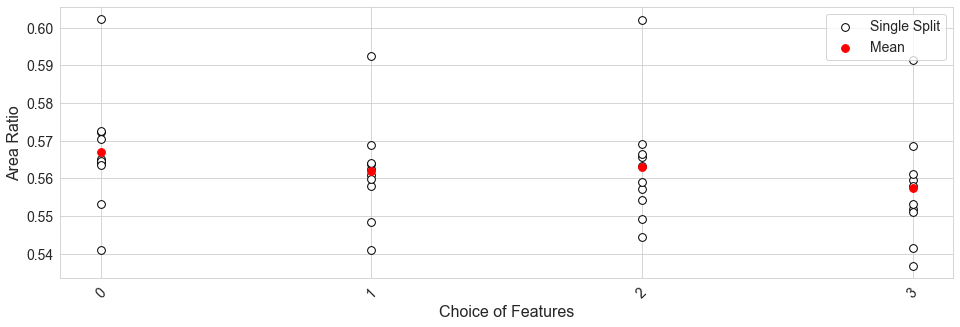

In [20]:
compare_area_ratios(df_train, randomforest, [statics + demogs + pays + billfracs + billamts + chargeamts,
                                            statics + demogs + pays + billfracs + billamts,
                                            statics + demogs + pays + billfracs + chargeamts,
                                            statics + demogs + pays + billamts + chargeamts,])

Indeed, as we were expecting, option 0 with all three types is the best.

And then let's check that adding any other monetary feature type to these three doesn't give a significant improvement.

0
['LIMIT_BAL', 'AGE', 'SEX', 'MARRIAGE', 'EDUCATION', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_FRAC1', 'BILL_FRAC2', 'BILL_FRAC3', 'BILL_FRAC4', 'BILL_FRAC5', 'BILL_FRAC6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'CHARGE_AMT1', 'CHARGE_AMT2', 'CHARGE_AMT3', 'CHARGE_AMT4', 'CHARGE_AMT5'] 

1
['LIMIT_BAL', 'AGE', 'SEX', 'MARRIAGE', 'EDUCATION', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_FRAC1', 'BILL_FRAC2', 'BILL_FRAC3', 'BILL_FRAC4', 'BILL_FRAC5', 'BILL_FRAC6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'CHARGE_AMT1', 'CHARGE_AMT2', 'CHARGE_AMT3', 'CHARGE_AMT4', 'CHARGE_AMT5', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'] 

2
['LIMIT_BAL', 'AGE', 'SEX', 'MARRIAGE', 'EDUCATION', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_FRAC1', 'BILL_FRAC2', 'BILL_FRAC3', 'BILL_FRAC4', 'BILL_FRAC5', 'BILL_FRAC6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 

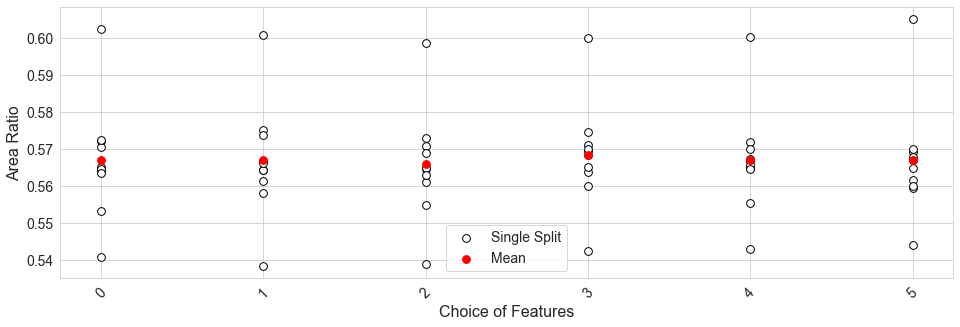

In [21]:
compare_area_ratios(df_train, randomforest, [statics + demogs + pays + billfracs + billamts + chargeamts,
                                              statics + demogs + pays + billfracs + billamts + chargeamts + payamts,
                                              statics + demogs + pays + billfracs + billamts + chargeamts + debtfracs,
                                              statics + demogs + pays + billfracs + billamts + chargeamts + payfracs,
                                              statics + demogs + pays + billfracs + billamts + chargeamts + debtamts,
                                              statics + demogs + pays + billfracs + billamts + chargeamts + debtdiffs])

Option 3, adding in payfracs, looks like a tiny improvement, but not clear enough to be worth including.

Now let's test whether it was actually helpful to include the limit balance and demographic information along with the payment lateness history and these three monetary feature types.

0
['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_FRAC1', 'BILL_FRAC2', 'BILL_FRAC3', 'BILL_FRAC4', 'BILL_FRAC5', 'BILL_FRAC6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'CHARGE_AMT1', 'CHARGE_AMT2', 'CHARGE_AMT3', 'CHARGE_AMT4', 'CHARGE_AMT5'] 

1
['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_FRAC1', 'BILL_FRAC2', 'BILL_FRAC3', 'BILL_FRAC4', 'BILL_FRAC5', 'BILL_FRAC6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'CHARGE_AMT1', 'CHARGE_AMT2', 'CHARGE_AMT3', 'CHARGE_AMT4', 'CHARGE_AMT5', 'LIMIT_BAL'] 

2
['LIMIT_BAL', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_FRAC1', 'BILL_FRAC2', 'BILL_FRAC3', 'BILL_FRAC4', 'BILL_FRAC5', 'BILL_FRAC6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'CHARGE_AMT1', 'CHARGE_AMT2', 'CHARGE_AMT3', 'CHARGE_AMT4', 'CHARGE_AMT5'] 

3
['LIMIT_BAL', 'AGE', 'SEX', 'MARRIAGE', 'EDUCATION', 'PAY_1', 'PAY_2', 'PAY_3

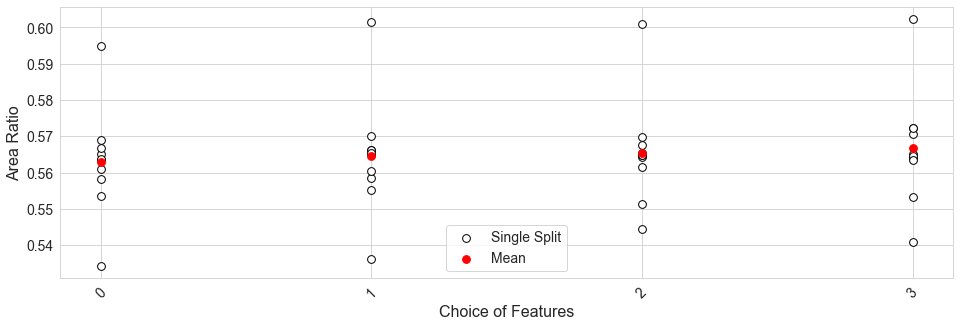

In [22]:
compare_area_ratios(df_train, randomforest, [pays + billfracs + billamts + chargeamts,
                                            pays + billfracs + billamts + chargeamts + ["LIMIT_BAL"],
                                            statics + pays + billfracs + billamts + chargeamts,
                                            statics + demogs + pays + billfracs + billamts + chargeamts])

We get a tiny improvement from including the limit balance and all the demographic information, but not enough (we decided) to be worth including.

Let's see which features the random forest algorithm uses the most, if we use our currently favorite collection: pays, billamts, chargeamts, and billfracs.

In [23]:
df_tt, df_ho = train_test_split(expand_columns(df_train.copy())[pays + billamts + chargeamts + billfracs + ["default payment next month"]],
                                        shuffle = True,
                                        random_state = 173,
                                        test_size = .2, 
                                        stratify = df_train["default payment next month"])

X_tt = df_tt.drop(columns=["default payment next month"])
y_tt = df_tt["default payment next month"]
pipe = RandomForestClassifier(n_estimators = 100, max_depth = 7, max_samples = 7000, random_state = 36830)
pipe.fit(X_tt, y_tt)
score_df = pd.DataFrame({'feature':X_tt.columns,
                            'importance_score': pipe.feature_importances_})

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(score_df.sort_values('importance_score',ascending=False))

,feature,importance_score
0,PAY_1,0.234779
1,PAY_2,0.123884
2,PAY_3,0.068144
4,PAY_5,0.060099
3,PAY_4,0.058539
5,PAY_6,0.054744
12,CHARGE_AMT1,0.041556
13,CHARGE_AMT2,0.031131
18,BILL_FRAC2,0.028929
14,CHARGE_AMT3,0.025928


Does omitting any of these supposedly less-used columns give just as good area ratios?  Let's test what happens with all combinations of, for each of the three monetary feature types, we either include all months, include just the first month, or exclude.

0
['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_FRAC1', 'BILL_FRAC2', 'BILL_FRAC3', 'BILL_FRAC4', 'BILL_FRAC5', 'BILL_FRAC6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'CHARGE_AMT1', 'CHARGE_AMT2', 'CHARGE_AMT3', 'CHARGE_AMT4', 'CHARGE_AMT5'] 

1
['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_FRAC1', 'BILL_FRAC2', 'BILL_FRAC3', 'BILL_FRAC4', 'BILL_FRAC5', 'BILL_FRAC6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'CHARGE_AMT1'] 

2
['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_FRAC1', 'BILL_FRAC2', 'BILL_FRAC3', 'BILL_FRAC4', 'BILL_FRAC5', 'BILL_FRAC6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'] 

3
['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_FRAC1', 'BILL_FRAC2', 'BILL_FRAC3', 'BILL_FRAC4', 'BILL_FRAC5', 'BILL_FRAC6', 'BILL_AMT1', 'CHARGE_AMT1', 'CHARGE_AMT2', 'CHARGE_AMT3', 'CHARGE_AMT4', 'CHARGE_AMT5'] 

4
['PAY_1', 'PAY

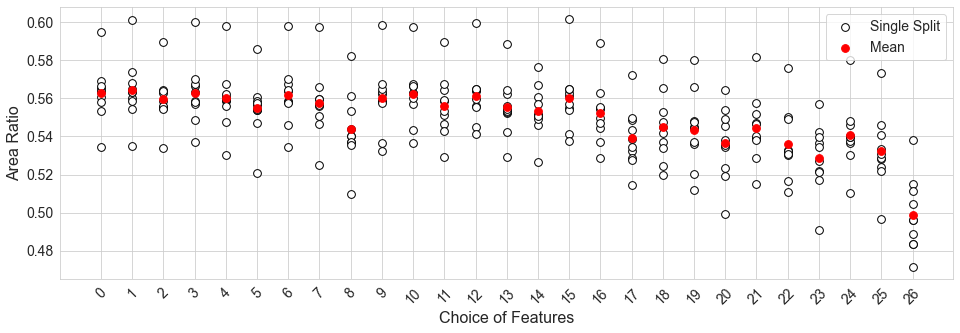

In [24]:
compare_area_ratios(df_train, randomforest, [pays + billfracs + billamts + chargeamts,
                                            pays + billfracs + billamts + ["CHARGE_AMT1"],
                                            pays + billfracs + billamts,
                                            pays + billfracs + ["BILL_AMT1"] + chargeamts,
                                            pays + billfracs + ["BILL_AMT1"] + ["CHARGE_AMT1"],
                                            pays + billfracs + ["BILL_AMT1"],
                                            pays + billfracs + chargeamts,
                                            pays + billfracs + ["CHARGE_AMT1"],
                                            pays + billfracs,
                                            pays + ["BILL_FRAC1"] + billamts + chargeamts,
                                            pays + ["BILL_FRAC1"] + billamts + ["CHARGE_AMT1"],
                                            pays + ["BILL_FRAC1"] + billamts,
                                            pays + ["BILL_FRAC1"] + ["BILL_AMT1"] + chargeamts,
                                            pays + ["BILL_FRAC1"] + ["BILL_AMT1"] + ["CHARGE_AMT1"],
                                            pays + ["BILL_FRAC1"] + ["BILL_AMT1"],
                                            pays + ["BILL_FRAC1"] + chargeamts,
                                            pays + ["BILL_FRAC1"] + ["CHARGE_AMT1"],
                                            pays + ["BILL_FRAC1"],
                                            pays + billamts + chargeamts,
                                            pays + billamts + ["CHARGE_AMT1"],
                                            pays + billamts,
                                            pays + ["BILL_AMT1"] + chargeamts,
                                            pays + ["BILL_AMT1"] + ["CHARGE_AMT1"],
                                            pays + ["BILL_AMT1"],
                                            pays + chargeamts,
                                            pays + ["CHARGE_AMT1"],
                                            pays])

It looks like not much harm is done from demoting any one of the three feature types to just the most recent month, maybe any two of them, but for conceptual simplicity, let's keep all of them in.

Our final list of features:
- all 6 months of payment lateness information, as it appears in the original spreadsheet
- all 6 months of billing amounts, as they appear in the original spreadsheet
- all 6 months of (billing amount) / (credit limit)
- all 5 months of charge amount = (billing amount this month) - ( (billing amount last month) - (payment amount this month) )

Now that we have this list of features, let's double-check that our comparison of model types is still valid.  Just like in the previous notebook, we give a summary of the performance of the various model types (each with parameters chosen in the previous notebook) under different metrics.

In [28]:
def preprocess(df_original):
    return expand_columns(df_original)[pays+billfracs + billamts + chargeamts]

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

def model_single_lateness(X_train, y_train, X_test, param):
    predp = np.zeros(len(X_test))
    for v in X_test["PAY_0"].unique():
        tot_train = sum(X_test["PAY_0"] == v)
        if tot_train > 0:
            proportion = sum((X_train["PAY_0"] == v) & (y_train == 1))/tot_train
        else:
            proportion = sum(y_train)/len(y_train)
        predp = (X_test["PAY_0"] != v) * predp + (X_test["PAY_0"] == v) * proportion
    return predp

def knn(X_train, y_train, X_test, param):
    frac, k = param
    pipe = Pipeline([("scale", StandardScaler()), 
                     ("pca", PCA(frac)), 
                     ("knn", KNeighborsClassifier(k))])
    pipe.fit(preprocess(X_train), y_train)
    return pipe.predict_proba(preprocess(X_test))[:,1]

def lda(X_train, y_train, X_test, param):
    pipe = LinearDiscriminantAnalysis()
    pipe.fit(preprocess(X_train), y_train)
    return pipe.predict_proba(preprocess(X_test))[:,1]

def qda(X_train, y_train, X_test, param):
    pipe = Pipeline([("scale", StandardScaler()), 
                     ("pca", PCA(.9)), 
                     ("qda", QuadraticDiscriminantAnalysis())])
    pipe.fit(preprocess(X_train), y_train)
    return pipe.predict_proba(preprocess(X_test))[:,1]

def naivebayes(X_train, y_train, X_test, param):
    pipe = GaussianNB()
    pipe.fit(preprocess(X_train), y_train)
    return pipe.predict_proba(preprocess(X_test))[:,1]


def decisiontree(X_train, y_train, X_test, param):
    d = param[0]
    pipe = DecisionTreeClassifier(max_depth = d)
    pipe.fit(preprocess(X_train), y_train)
    return pipe.predict_proba(preprocess(X_test))[:,1]

def model_randomforest(X_train, y_train, X_test, param):
    n, d, s = param
    pipe = RandomForestClassifier(n_estimators = n, max_depth = d, max_samples = s)
    pipe.fit(preprocess(X_train), y_train)
    return pipe.predict_proba(preprocess(X_test))[:,1]

def extratrees(X_train, y_train, X_test, param):
    n, d, s = param
    pipe = ExtraTreesClassifier(n_estimators = n, max_depth = d, max_samples = s, bootstrap = True)
    pipe.fit(preprocess(X_train), y_train)
    return pipe.predict_proba(preprocess(X_test))[:,1]

def ada(X_train, y_train, X_test, param):
    n = param[0]
    pipe = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), 
                              n_estimators=n)
    pipe.fit(preprocess(X_train), y_train)
    return pipe.predict_proba(preprocess(X_test))[:,1]

def gradboost(X_train, y_train, X_test, param):
    n, rate = param
    pipe = GradientBoostingClassifier(n_estimators=n, 
                                     max_depth=1, 
                                     learning_rate=rate)
    pipe.fit(preprocess(X_train), y_train)
    return pipe.predict_proba(preprocess(X_test))[:,1]

In [29]:
from sklearn.metrics import confusion_matrix

#returns in order: (0,0), (0,1), (1,0), (1,1)
def conf_matrix_components(cutoffs, true_data, predicted_prob):
    tp_s=[]
    fp_s=[]
    tn_s=[]
    fn_s=[]
    
    for cutoff in cutoffs:
        pred_cutoff=1*(predicted_prob >=cutoff)
        cmat=confusion_matrix(true_data, pred_cutoff)
        tn = cmat[0][0]
        tp = cmat[1][1]
        fp = cmat[0][1]
        fn = cmat[1][0]
        
        tp_s.append(tp)
        tn_s.append(tn)
        fp_s.append(fp)
        fn_s.append(fn)
        
    return [tn_s, fp_s, fn_s, tp_s]

#precision scores given list of confusion matrix components in left-to-right and up-to-down order
#similarly for the rest of the functions
def prec_scores(list_comps):
    fp_s=list_comps[1]
    tp_s=list_comps[3]
    prec=np.zeros(len(fp_s))
    for i in range(len(tp_s)):
        if tp_s[i]!=0 or fp_s[i]!=0:
            prec[i]=tp_s[i]/(tp_s[i]+fp_s[i])
    return prec;


def recall_scores(list_comps):
    tp_s=list_comps[3]
    fn_s=list_comps[2]
    rec= [tp_s[i]/(tp_s[i]+fn_s[i]) for i in range(len(tp_s))]
    return rec;

def f1_scores(list_comps):
    p=prec_scores(list_comps)
    r=recall_scores(list_comps)
    f1=np.zeros(len(p));
    for i in range(len(p)):
        if p[i]!=0 or r[i]!=0:
            f1[i]= (2*p[i]*r[i])/(p[i]+r[i])
    return list(f1)

def accuracy(list_comps):
    tn, fp, fn, tp = list_comps
    acc=[(tn[i]+tp[i])/(tn[i]+tp[i] + fp[i]+fn[i]) for i in range(len(tp))]
    return acc;

def weighted_accuracy(list_comps):
    #(1/2)*(tn/#true 0s + tp/# true 1s)
    tn, fp, fn, tp = list_comps
    w_acc=[(0.5)*(tn[i]/(tn[i] + fp[i])) + (0.5)*(tp[i]/(tp[i] + fn[i])) for i in range(len(tp)) ]
    return w_acc

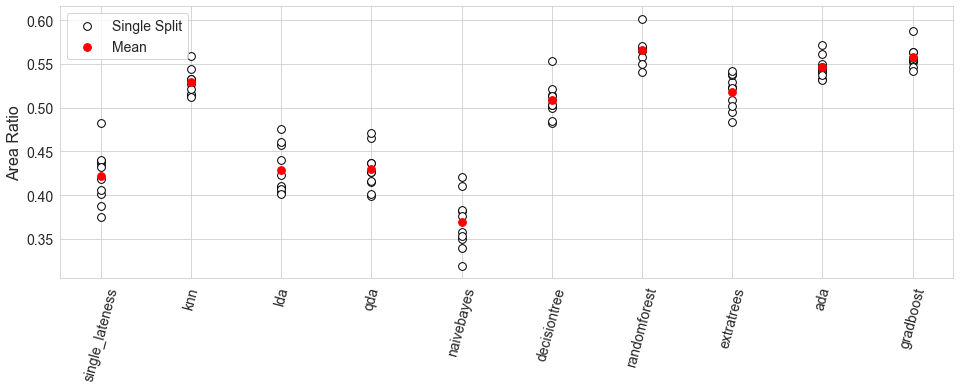

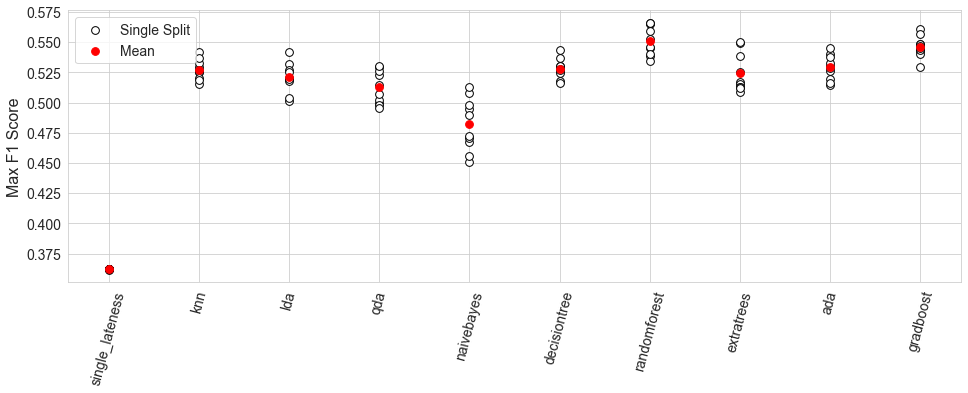

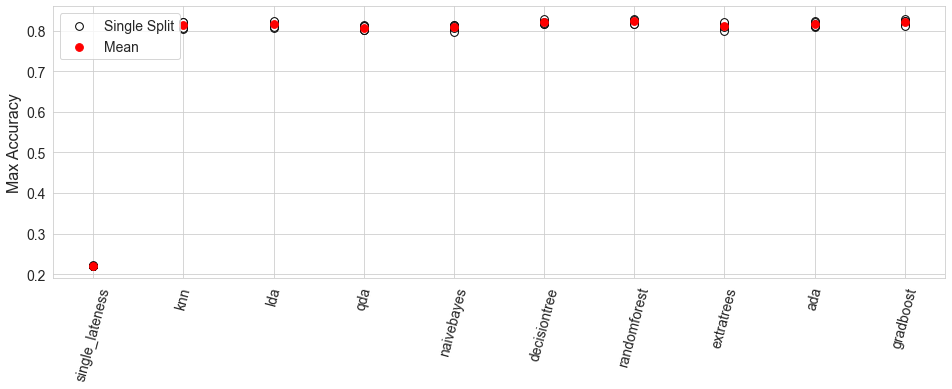

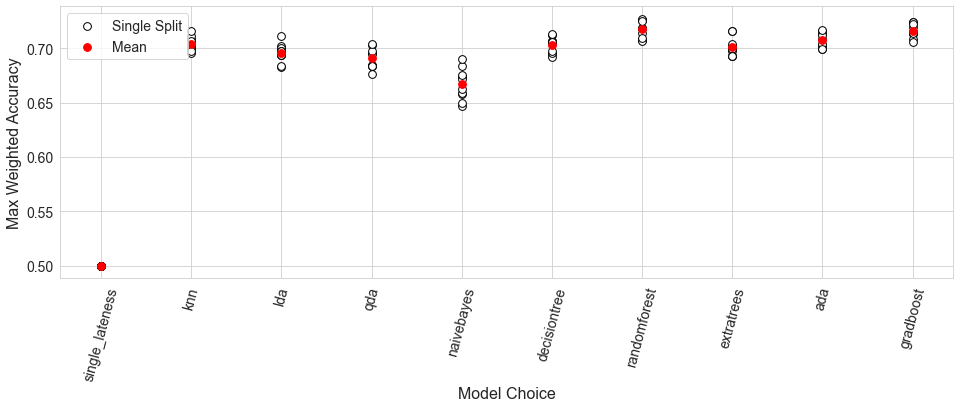

In [30]:
from sklearn.model_selection import StratifiedKFold

modelslist = [(model_single_lateness, (None,)),
             (knn, (.99, 160)),
             (lda, (None,)),
             (qda, (None,)),
             (naivebayes, (None,)),
             (decisiontree, (6,)),
             (model_randomforest, (100, 7, 7000)),
             (extratrees, (60, 5, 80)),
             (ada, (32,)),
             (gradboost, (96, .4))]

areas = np.zeros((len(modelslist), 10))
f1_s = np.zeros((len(modelslist), 10))
acc_s = np.zeros((len(modelslist), 10))
wacc_s = np.zeros((len(modelslist), 10))

cutoffs=np.arange(1,0,-0.01)
kfold = StratifiedKFold(n_splits = 10, 
                        shuffle = True, 
                        random_state = 173)
X = df_train.drop(columns=["default payment next month"])
y = df_train["default payment next month"]
i = 0
for train_index, test_index in kfold.split(X, y):
    X_tt = X.iloc[train_index]
    y_tt = y.iloc[train_index]
    X_ho = X.iloc[test_index]
    y_ho = y.iloc[test_index]

    for j, m in enumerate(modelslist):
        model, param = m
        predproba = model(X_tt, y_tt, X_ho, param)
        
        areas[j,i] = area_ratio(y_ho.values, predproba)
        cmat_list = conf_matrix_components(cutoffs, y_ho.values, predproba)
        f1_s[j,i] = max(f1_scores(cmat_list))
        acc_s[j,i] = max(accuracy(cmat_list))
        wacc_s[j,i] = max(weighted_accuracy(cmat_list))

    i += 1

## This figure will compare the area ratios
plt.figure(figsize=(16,5))

for j in range(len(modelslist)):
    if j == 0:
        plt.scatter(j*np.ones(10), 
                areas[j,:], 
                s=60, 
                c='white',
                edgecolor='black',
                label="Single Split")
    else:
        plt.scatter(j*np.ones(10), 
                areas[j,:], 
                s=60, 
                c='white',
                edgecolor='black')

plt.scatter(range(len(modelslist)), np.mean(areas, axis=1), s=60, c='r', label="Mean")

plt.legend(fontsize=14)

plt.xticks(range(len(modelslist)), ["single_lateness", 
                                    "knn", 
                                    "lda", 
                                    "qda", 
                                    "naivebayes", 
                                    "decisiontree", 
                                    "randomforest", 
                                    "extratrees", 
                                    "ada", 
                                    "gradboost"], fontsize=14, rotation=75)
plt.yticks(fontsize=14)

#plt.xlabel("Model Choice", fontsize=16)
plt.ylabel("Area Ratio", fontsize=16)

plt.show()

## This figure will compare the max f1 scores
plt.figure(figsize=(16,5))

for j in range(len(modelslist)):
    if j == 0:
        plt.scatter(j*np.ones(10), 
                f1_s[j,:], 
                s=60, 
                c='white',
                edgecolor='black',
                label="Single Split")
    else:
        plt.scatter(j*np.ones(10), 
                f1_s[j,:], 
                s=60, 
                c='white',
                edgecolor='black')

plt.scatter(range(len(modelslist)), np.mean(f1_s, axis=1), s=60, c='r', label="Mean")

plt.legend(fontsize=14)

plt.xticks(range(len(modelslist)), ["single_lateness", 
                                    "knn", 
                                    "lda", 
                                    "qda", 
                                    "naivebayes", 
                                    "decisiontree", 
                                    "randomforest", 
                                    "extratrees", 
                                    "ada", 
                                    "gradboost"], fontsize=14, rotation=75)
plt.yticks(fontsize=14)

#plt.xlabel("Model Choice", fontsize=16)
plt.ylabel("Max F1 Score", fontsize=16)

plt.show()


## This figure will compare the max accuracies
plt.figure(figsize=(16,5))

for j in range(len(modelslist)):
    if j == 0:
        plt.scatter(j*np.ones(10), 
                acc_s[j,:], 
                s=60, 
                c='white',
                edgecolor='black',
                label="Single Split")
    else:
        plt.scatter(j*np.ones(10), 
                acc_s[j,:], 
                s=60, 
                c='white',
                edgecolor='black')

plt.scatter(range(len(modelslist)), np.mean(acc_s, axis=1), s=60, c='r', label="Mean")

plt.legend(fontsize=14)

plt.xticks(range(len(modelslist)), ["single_lateness", 
                                    "knn", 
                                    "lda", 
                                    "qda", 
                                    "naivebayes", 
                                    "decisiontree", 
                                    "randomforest", 
                                    "extratrees", 
                                    "ada", 
                                    "gradboost"], fontsize=14, rotation=75)
plt.yticks(fontsize=14)

#plt.xlabel("Model Choice", fontsize=16)
plt.ylabel("Max Accuracy", fontsize=16)

plt.show()


## This figure will compare the max weighted accuracies
plt.figure(figsize=(16,5))

for j in range(len(modelslist)):
    if j == 0:
        plt.scatter(j*np.ones(10), 
                wacc_s[j,:], 
                s=60, 
                c='white',
                edgecolor='black',
                label="Single Split")
    else:
        plt.scatter(j*np.ones(10), 
                wacc_s[j,:], 
                s=60, 
                c='white',
                edgecolor='black')

plt.scatter(range(len(modelslist)), np.mean(wacc_s, axis=1), s=60, c='r', label="Mean")

plt.legend(fontsize=14)

plt.xticks(range(len(modelslist)), ["single_lateness", 
                                    "knn", 
                                    "lda", 
                                    "qda", 
                                    "naivebayes", 
                                    "decisiontree", 
                                    "randomforest", 
                                    "extratrees", 
                                    "ada", 
                                    "gradboost"], fontsize=14, rotation=75)
plt.yticks(fontsize=14)

plt.xlabel("Model Choice", fontsize=16)
plt.ylabel("Max Weighted Accuracy", fontsize=16)

plt.show()

The new choice of columns has improved some of the scores, but has not changed the overall conclusion: random forest and gradient boost are approximately tied for best.  Now, actually, random forest seems to be doing very slightly better than gradient boost on all scores.